<a href="https://colab.research.google.com/github/Jeetmu/telecom_churn_analysis_pyspark/blob/main/Churn_Analysis_pyspark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install findspark

In [2]:
!pip install pyspark

In [3]:
import findspark
findspark.init()

In [4]:
from pyspark.sql import SparkSession

In [5]:
# spark initialization

spark = SparkSession.builder.appName("ChurnAnalysis").getOrCreate()

In [6]:
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import CrossValidator
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
df = spark.read.csv("churn/Churn.csv", header=True, inferSchema=True)
df.show()

+-------------+------------+-------+-------+---------+--------+-------------+-----+--------+---------+--------+---------+--------+---------+----------+-----------+---------+----------+-----+--------+--------+
|AccountLength|VMailMessage|DayMins|EveMins|NightMins|IntlMins|CustServCalls|Churn|IntlPlan|VMailPlan|DayCalls|DayCharge|EveCalls|EveCharge|NightCalls|NightCharge|IntlCalls|IntlCharge|State|AreaCode|   Phone|
+-------------+------------+-------+-------+---------+--------+-------------+-----+--------+---------+--------+---------+--------+---------+----------+-----------+---------+----------+-----+--------+--------+
|          128|          25|  265.1|  197.4|    244.7|    10.0|            1|    0|       0|        1|     110|    45.07|      99|    16.78|        91|      11.01|        3|       2.7|   KS|     415|382-4657|
|          107|          26|  161.6|  195.5|    254.4|    13.7|            1|    0|       0|        1|     123|    27.47|     103|    16.62|       103|      11.45| 

In [8]:
df.describe()

DataFrame[summary: string, AccountLength: string, VMailMessage: string, DayMins: string, EveMins: string, NightMins: string, IntlMins: string, CustServCalls: string, Churn: string, IntlPlan: string, VMailPlan: string, DayCalls: string, DayCharge: string, EveCalls: string, EveCharge: string, NightCalls: string, NightCharge: string, IntlCalls: string, IntlCharge: string, State: string, AreaCode: string, Phone: string]

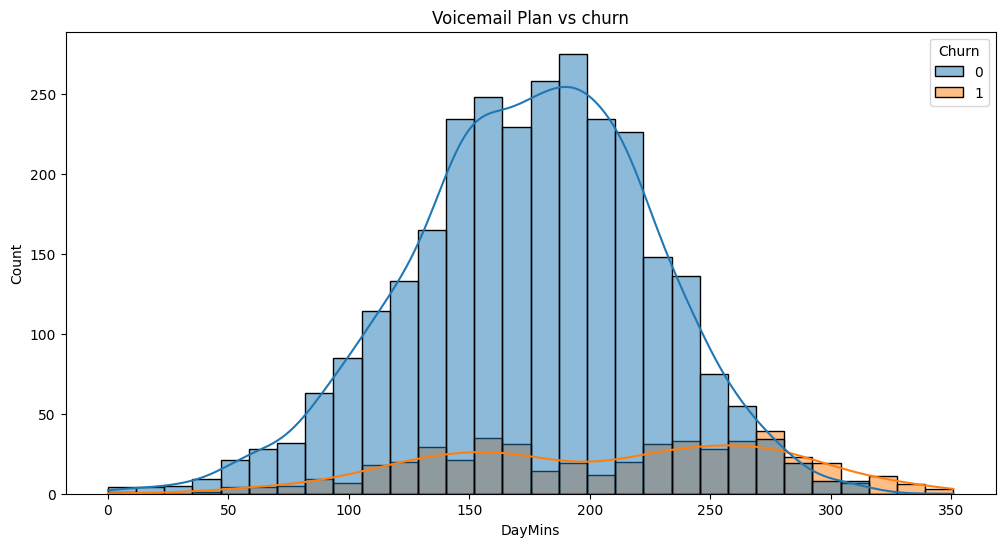

In [9]:
#creating histogram for Day minutes spent by customers for churn= 0 and 1
plt.figure(figsize=(12,6))
sns.histplot(data=df.toPandas(), x='DayMins', hue="Churn", bins=30, kde=True)
plt.title("Voicemail Plan vs churn")
plt.show()

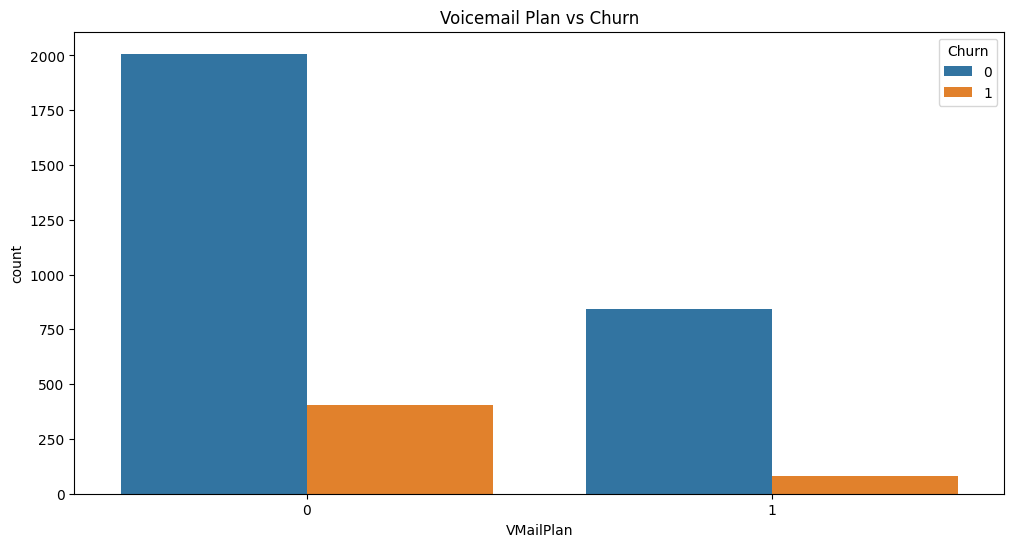

In [10]:
# create count plots for Numbers of customer opt voicemail plan with churn values
plt.figure(figsize=(12,6))
sns.countplot(data=df.toPandas(), x="VMailPlan", hue="Churn")
plt.title("Voicemail Plan vs Churn")
plt.show()

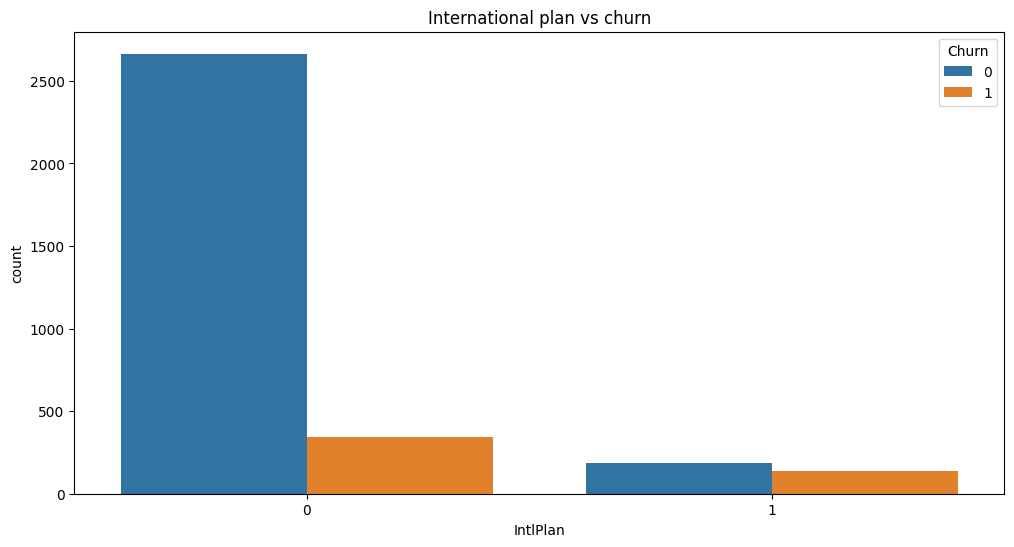

In [11]:
#Create count plots for International Plan opt by the customer with Churn values.
plt.figure(figsize=(12,6))
sns.countplot(data=df.toPandas(), x="IntlPlan", hue="Churn")
plt.title("International plan vs churn")
plt.show()

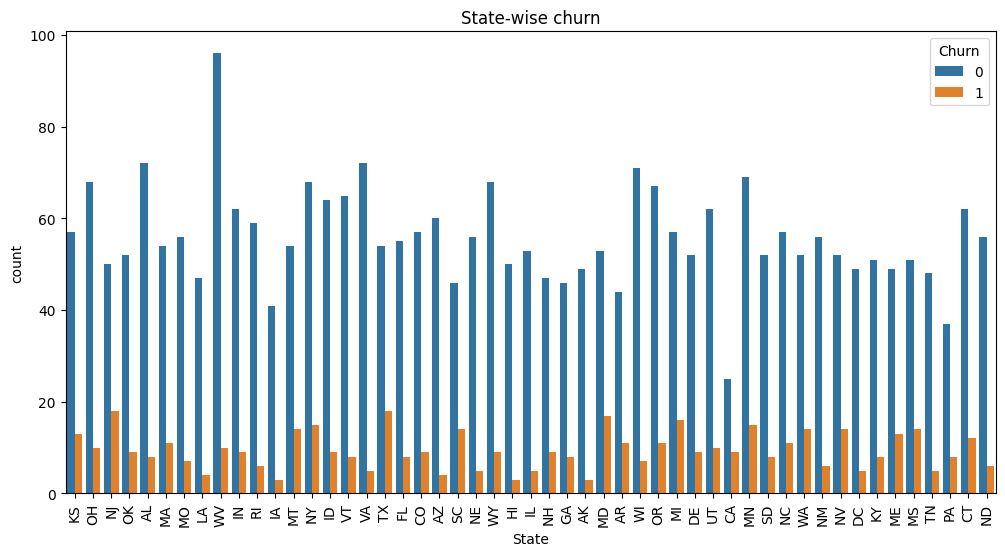

In [12]:
# plot state wise churner and non-churner
plt.figure(figsize=(12,6))
sns.countplot(data=df.toPandas(), x="State", hue="Churn")
plt.title("State-wise churn")
plt.xticks(rotation=90)
plt.show()

In [13]:
# correlation matrix
correlation_matrix = df.select([F.corr("Churn", col).alias(col) for col in df.columns]).toPandas()
correlation_matrix

,AccountLength,VMailMessage,DayMins,EveMins,NightMins,IntlMins,CustServCalls,Churn,IntlPlan,VMailPlan,...,DayCharge,EveCalls,EveCharge,NightCalls,NightCharge,IntlCalls,IntlCharge,State,AreaCode,Phone
0,0.016541,-0.089728,0.205151,0.092796,0.035493,0.068239,0.20875,1.0,0.259852,-0.102148,...,0.205151,0.009233,0.092786,0.006141,0.035496,-0.052844,0.068259,NaN,0.006174,NaN


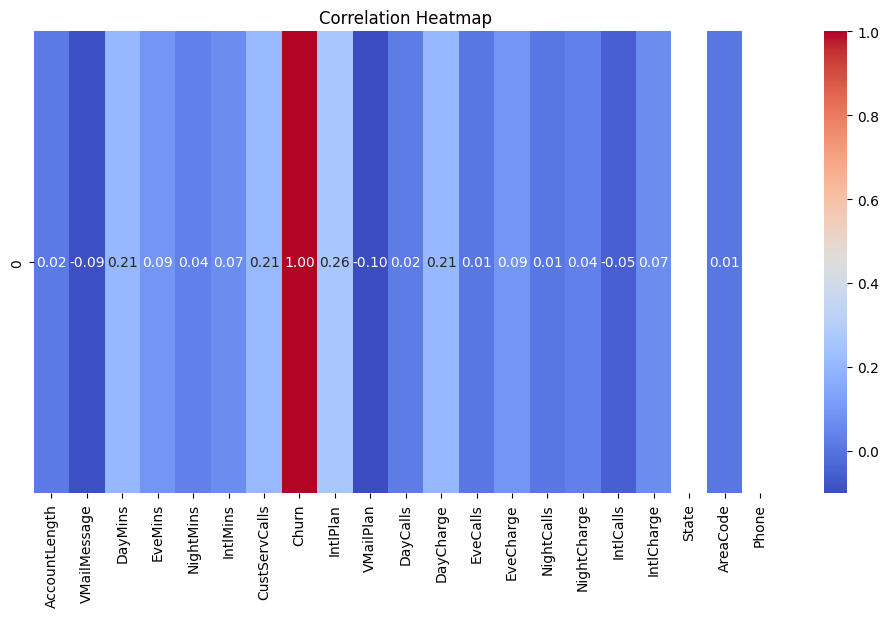

In [14]:
# heatmap
plt.figure(figsize=(12,6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [15]:
# Independent variable
feature_cols = ["AccountLength", "VMailMessage", "DayMins", "EveMins", "NightMins", "IntlMins",
                "CustServCalls", "IntlPlan", "VMailPlan", "DayCalls", "DayCharge", "EveCalls",
                "EveCharge", "NightCalls", "NightCharge", "IntlCalls", "IntlCharge"]

In [16]:
# Convert the 'State' column to a numerical format using StringIndexer
state_indexer = StringIndexer(inputCol="State", outputCol="StateIndex")
data = state_indexer.fit(df).transform(df)

In [17]:
data.show()

+-------------+------------+-------+-------+---------+--------+-------------+-----+--------+---------+--------+---------+--------+---------+----------+-----------+---------+----------+-----+--------+--------+----------+
|AccountLength|VMailMessage|DayMins|EveMins|NightMins|IntlMins|CustServCalls|Churn|IntlPlan|VMailPlan|DayCalls|DayCharge|EveCalls|EveCharge|NightCalls|NightCharge|IntlCalls|IntlCharge|State|AreaCode|   Phone|StateIndex|
+-------------+------------+-------+-------+---------+--------+-------------+-----+--------+---------+--------+---------+--------+---------+----------+-----------+---------+----------+-----+--------+--------+----------+
|          128|          25|  265.1|  197.4|    244.7|    10.0|            1|    0|       0|        1|     110|    45.07|      99|    16.78|        91|      11.01|        3|       2.7|   KS|     415|382-4657|      16.0|
|          107|          26|  161.6|  195.5|    254.4|    13.7|            1|    0|       0|        1|     123|    27.47

In [18]:
assembler = VectorAssembler(inputCols=feature_cols + ["StateIndex"], outputCol="features")
data = assembler.transform(data)

In [19]:
data.show()

+-------------+------------+-------+-------+---------+--------+-------------+-----+--------+---------+--------+---------+--------+---------+----------+-----------+---------+----------+-----+--------+--------+----------+--------------------+
|AccountLength|VMailMessage|DayMins|EveMins|NightMins|IntlMins|CustServCalls|Churn|IntlPlan|VMailPlan|DayCalls|DayCharge|EveCalls|EveCharge|NightCalls|NightCharge|IntlCalls|IntlCharge|State|AreaCode|   Phone|StateIndex|            features|
+-------------+------------+-------+-------+---------+--------+-------------+-----+--------+---------+--------+---------+--------+---------+----------+-----------+---------+----------+-----+--------+--------+----------+--------------------+
|          128|          25|  265.1|  197.4|    244.7|    10.0|            1|    0|       0|        1|     110|    45.07|      99|    16.78|        91|      11.01|        3|       2.7|   KS|     415|382-4657|      16.0|[128.0,25.0,265.1...|
|          107|          26|  161.6|

In [22]:
# Machine Learning Model - Decision Tree using dependent and independent variable
dt = DecisionTreeClassifier(maxBins=100, labelCol="Churn", featuresCol="features")
# pipeline
pipeline_dt = Pipeline(stages=[dt])

# split
sampled_data = data.sampleBy("Churn", fractions={0:0.7, 1:0.7}, seed=42)
train_data, test_data = sampled_data.randomSplit([0.7, 0.3], seed=42)



In [23]:
#Make predictions and validate your model by calculating the accuracy score.
model_dt = pipeline_dt.fit(train_data)
prediction_dt = model_dt.transform(test_data)

In [24]:
# evaluate
evaluator = MulticlassClassificationEvaluator(labelCol="Churn", predictionCol="prediction", metricName="accuracy")
accuracy_dt = evaluator.evaluate(prediction_dt)

In [28]:
print("accuracy: ",accuracy_dt)

accuracy:  0.9280245022970903


In [27]:
# calculate recall and precision score
recall_dt = evaluator.setMetricName("weightedRecall").evaluate(prediction_dt)
precision_dt = evaluator.setMetricName("weightedPrecision").evaluate(prediction_dt)

print("recall: ", recall_dt)
print("precision: ", precision_dt)

recall:  0.9280245022970903
precision:  0.9244665660939066


In [29]:
# test the model using test data and calculate accuaracy
test_predictions_dt = model_dt.transform(test_data)
test_accuracy_dt = evaluator.evaluate(test_predictions_dt)
test_recall_dt = evaluator.setMetricName("weightedRecall").evaluate(test_predictions_dt)
test_precision_dt = evaluator.setMetricName("weightedPrecision").evaluate(test_predictions_dt)

print("accuracy: ", test_accuracy_dt)
print("recall: ", recall_dt)
print("precision: ", precision_dt)

accuracy:  0.9244665660939066
recall:  0.9280245022970903
precision:  0.9244665660939066


In [32]:
# Random Forest
rf = RandomForestClassifier(maxBins=100,labelCol="Churn", featuresCol="features")
pipeline_rf = Pipeline(stages=[rf])
model_rf = pipeline_rf.fit(train_data)
prediction_rf = model_rf.transform(test_data)

In [34]:
accuracy_rf = evaluator.evaluate(prediction_rf)
recall_rf = evaluator.setMetricName("weightedRecall").evaluate(prediction_rf)
precision_rf = evaluator.setMetricName("weightedPrecision").evaluate(prediction_rf)

print("accuracy: ", accuracy_rf)
print("recall: ", recall_rf)
print("precision: ", precision_rf)

accuracy:  0.9111791730474732
recall:  0.9111791730474732
precision:  0.9059672562901805


In [39]:
test_prediction_rf = model_rf.transform(test_data)
test_accuarcy_rf = evaluator.evaluate(test_prediction_rf)
test_recall_rf = evaluator.setMetricName("weightedRecall").evaluate(test_prediction_rf)
test_precision_rf = evaluator.setMetricName("weightedPrecision").evaluate(test_prediction_rf)

print("accuracy: ", test_accuarcy_rf)
print("recall: ", test_recall_rf)
print("precision: ", test_precision_rf)

accuracy:  0.9059672562901805
recall:  0.9111791730474732
precision:  0.9059672562901805


In [42]:
gbt = GBTClassifier(maxBins=100,labelCol="Churn", featuresCol="features")
pipeline_gbt = Pipeline(stages=[gbt])
model_gbt = pipeline_gbt.fit(train_data)
prediction_gbt = model_gbt.transform(test_data)

In [44]:
accuracy_gbt = evaluator.evaluate(prediction_gbt)
recall_gbt = evaluator.setMetricName("weightedRecall").evaluate(prediction_gbt)
precision_gbt = evaluator.setMetricName("weightedPrecision").evaluate(prediction_gbt)

print("accuracy: ", accuracy_gbt)
print("recall: ", recall_gbt)
print("precision: ", precision_gbt)

accuracy:  0.9203675344563552
recall:  0.9203675344563552
precision:  0.919529689743419
